# PDG ATTACK #

### *Import*

In [76]:
# LIBRERIE UTILI
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt
import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  False


### Inizio

In [77]:
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True



fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.

In [78]:
# Import attack
from torch.nn import CrossEntropyLoss
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

#Impostare l'input shape
classifier = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.


### Inizializzazione parametri

In [85]:
epsilon = 0.07 # max epsilon
eps_step = 0.01
max_iter = 7
""" epsilon = 0.03 # max epsilon
eps_step = 0.005
max_iter = 15 """
attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = epsilon, eps_step=eps_step, targeted=False, max_iter = max_iter)

### Caricamento singola immagine di test

In [87]:
# Import the attack
from art.attacks.evasion import FastGradientMethod
from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
from torchvision import transforms
from PIL import Image

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.

test_img = load_image("test_set_cropped/Diego_Maradona_4_face_0.jpg")

print(test_img.shape)
print(test_img.size)
test_img = test_img.unsqueeze(0)
print(test_img.shape)
print(test_img.size)
test_img = test_img.numpy()
print(test_img.shape)
print(type(test_img))

torch.Size([3, 160, 160])
<built-in method size of Tensor object at 0x000001C91FDEA220>
torch.Size([1, 3, 160, 160])
<built-in method size of Tensor object at 0x000001C91FDC1770>
(1, 3, 160, 160)
<class 'numpy.ndarray'>


### Error Generic PGD attack

#### *Su singola immagine di test*

In [88]:
# PGD generic Attack for single sample

test_images_adv = attack.generate(test_img)  # Utilizzare generate per generare i campion
model_predictions = classifier.predict(test_images_adv) # Classifier
predicted_label = LABELS[np.array(model_predictions.argmax())] 
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

 Matt_Berninger con probabilità 11.32913589477539


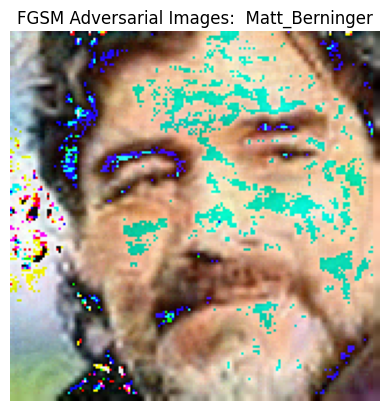

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Supponiamo che test_images_adv sia un array numpy con forma (1, 3, 160, 160)
# Rimuoviamo la dimensione batch extra
test_images_adv = np.squeeze(test_images_adv, axis=0)  # Ora la forma è (3, 160, 160)

# Trasponiamo l'array per convertirlo nel formato channels-last
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))  # Ora la forma è (160, 160, 3)

# Convertiamo in tipo uint8 se necessario
if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizziamo l'immagine con Matplotlib
plt.imshow(test_images_adv)
plt.title("FGSM Adversarial Images: " + predicted_label)
plt.axis('off')  # Disabilita gli assi
plt.show()



#### *Su tutte le immagini di test*

In [ ]:
# PGD generic Attack for all samples
import os
import re

dataset_dir = "test_set_cropped_piccolo/" 
eps_step = [0.00002, 0.00005, 0.00007, 0.0002, 0.0005, 0.0007, 0.002, 0.005, 0.007, 0.01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
#eps_range = [0.001, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7] #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).
eps_range = 0.01

accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = eps_range, eps_step=step, targeted=False, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# correct_predictions = 0
# total_images = 0
# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

Inizio Attacco PGD NON-TARGETED
**** Attacco con max_iter 2 **** 
**** Attacco con eps:0.01 con step a 2e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.69382381439209 e con perturbazione 3.826684405794367e-05
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.453540802001953 e con perturbazione 3.811258284258656e-05
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.097886085510254 e con perturbazione 3.7907419027760625e-05
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


KeyboardInterrupt: 

### Error Specific PGD attack

In [ ]:
epsilon = 1
eps_step = 0.1
max_iter = 1 

attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = epsilon, eps_step= eps_step, targeted=True, max_iter = max_iter)

In [ ]:
#PGD specific Attack for single sample

target_class = 10 

batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

print(one_hot_targeted_labels.shape)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)


model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print("Etichetta target:{}".format(LABELS[target_class]))
print(model_predictions)
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

(1, 8631)


Average perturbation: 0.10
Etichetta target: Aaron_Hernandez
[[ 1.6927811   1.0017549   1.155009   ... -2.9755855  -0.04593772
  -2.0825043 ]]
 Osman_Nuri_Topbaş con probabilità 6.552561283111572


#### *Su singola immagine di test*

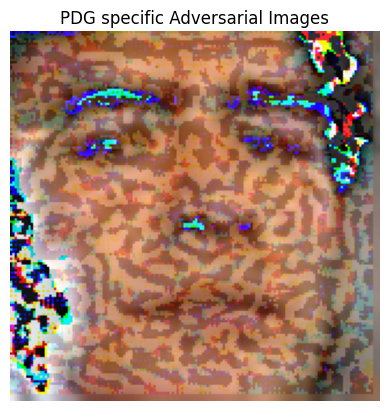

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Supponiamo che test_images_adv sia un array numpy con forma (1, 3, 160, 160)
# Rimuoviamo la dimensione batch extra
test_images_adv = np.squeeze(test_images_adv, axis=0)  # Ora la forma è (3, 160, 160)

# Trasponiamo l'array per convertirlo nel formato channels-last
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))  # Ora la forma è (160, 160, 3)

# Convertiamo in tipo uint8 se necessario
if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizziamo l'immagine con Matplotlib
plt.imshow(test_images_adv)
plt.title("PDG specific Adversarial Images: "+ predicted_label)
plt.axis('off')  # Disabilita gli assi
plt.show()



#### *Su tutte le immagini di test*

In [ ]:
#PGD specific Attack for all samples
import os
import re

dataset_dir = "test_set_cropped_piccolo/" 
#eps_step = [0.0002, 0.0002, 0.0002, 0.001, 0.002, 0.002, 0.01, 0.02, 0.05] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.
eps_step = [0.0002,0.002]
max_iter = [1,2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
#eps_range = [0.001, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7] #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).
eps_range = 0.7

accuracy_misclassified_for_eps = []
accuracy_misclassified_for_max_iter = []
accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_misclassified = 0
total_images = 0

target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])
batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = eps_range, eps_step=step, targeted=True, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1
                        
                    if etichetta_target in predicted_label:  
                        correct_misclassified = correct_misclassified+1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    accuracy_misclassified = correct_misclassified/total_images
                    print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))
                
                accuracy_misclassified = correct_misclassified/total_images
                accuracy_misclassified_for_eps.append(accuracy_misclassified)
                print("----------- Adversarial Sample misclassificati correttamente: {}% -----------".format((accuracy_misclassified)))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []

        if True:
            accuracy__misclassified_media_per_max_iter = sum(accuracy_misclassified_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_misclassified_for_max_iter.append(accuracy__misclassified_media_per_max_iter)
            print("----------- Accuracy MISCLASSIFIED media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_misclassified_for_max_iter[i]))
            accuracy_misclassified_for_eps = []


        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")


# correct_predictions = 0
# total_images = 0
# target_class = 10
# print("ETICHETTA TARGET: ", LABELS[10])
# batch_size = test_img.shape[0]
# targeted_labels = np.array([target_class] * batch_size)
# one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

ETICHETTA TARGET:   Aaron_Hernandez
Inizio Attacco PGD NON-TARGETED
**** Attacco con max_iter 1 **** 
**** Attacco con eps:0.7 con step a 0.0002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.6244535446167 e con perturbazione 0.00019256384985055774
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.4779052734375 e con perturbazione 0.00019255444931332022
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.011988639831543 e con perturbazione 0.0001925574179040268
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.645259857177734 e con perturbazione 0.00019255466759204865
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.201181411743164 e con perturbazione 0.00019255338702350855
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt


Predetto  Brad_Pitt con probabilità 13.073996543884277 e con perturbazione 0.00019256114319432527
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica


Predetto  Christian_De_Sica con probabilità 13.623851776123047 e con perturbazione 0.00019256342784501612
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.956986427307129 e con perturbazione 0.00019256648374721408
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo


Predetto  Cristiano_Ronaldo con probabilità 12.877859115600586 e con perturbazione 0.0001925573596963659
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona


Predetto  Diego_Maradona con probabilità 12.195181846618652 e con perturbazione 0.00019256155064795166
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0001925593736814335% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo


Predetto  Andrea_Pirlo con probabilità 11.713324546813965 e con perturbazione 0.001925696968100965
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano


Predetto  Branch_Warren con probabilità 10.133880615234375 e con perturbazione 0.0019256871892139316
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Qin_Lan con probabilità 9.557045936584473 e con perturbazione 0.0019256907980889082
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 11.546131134033203 e con perturbazione 0.001925688236951828
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Boris_Johnson


Predetto  Boris_Johnson con probabilità 12.12099552154541 e con perturbazione 0.001925686956383288
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%


Etichetta corretta: Brad_Pitt


Predetto  Brad_Pitt con probabilità 11.947137832641602 e con perturbazione 0.0019256945233792067
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta:

 Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 12.394709587097168 e con perturbazione 0.0019256965024396777
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 71.42857142857143%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 10.674188613891602 e con perturbazione 0.0019256992964074016
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.10578441619873 e con perturbazione 0.0019256905652582645
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 77.77777777777779%


Etichetta corretta: Diego_Maradona


Predetto  Diego_Maradona con probabilità 9.61337947845459 e con perturbazione 0.0019256947562098503
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.0019256925792433322% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.8% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 1 sugli adversarial Sample: 0.001059125976462383\% ----------------
----------- Accuracy media con iterazione 1 sugli adversarial Sample: 0.8500000000000001\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 1 sugli adversarial Sample: 0.0\% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
****

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.525473594665527 e con perturbazione 0.0003698000800795853
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.447826385498047 e con perturbazione 0.0003685738774947822
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.844032287597656 e con perturbazione 0.0003622204822022468
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.39244556427002 e con perturbazione 0.0003675847838167101
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.07414722442627 e con perturbazione 0.0003674260515253991
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.94344425201416 e con perturbazione 0.0003668366698548198
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.49453353881836 e con perturbazione 0.00036704412195831537
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.828258514404297 e con perturbazione 0.0003649822610896081
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.809643745422363 e con perturbazione 0.0003681209054775536
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.940610885620117 e con perturbazione 0.00032977666705846786
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0003632365900557488% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 10.869651794433594 e con perturbazione 0.003345562145113945
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 9.641151428222656 e con perturbazione 0.0032443483360111713
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Mai_Phương_Thúy con probabilità 8.752038955688477 e con perturbazione 0.0029601887799799442
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 9.61050796508789 e con perturbazione 0.0031028406228870153
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 10.887495994567871 e con perturbazione 0.003230649745091796
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 10.772216796875 e con perturbazione 0.003201912622898817
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 10.907539367675781 e con perturbazione 0.0032038954086601734
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 71.42857142857143%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 9.528176307678223 e con perturbazione 0.003085931995883584
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 62.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 11.130282402038574 e con perturbazione 0.0032271139789372683
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Diego_Maradona
Predetto  Paolo_Goltz con probabilità 10.350704193115234 e con perturbazione 0.002507593482732773
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.0031110037118196486% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.6% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 2 sugli adversarial Sample: 0.0017371201509376987\% ----------------
----------- Accuracy media con iterazione 2 sugli adversarial Sample: 0.75\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 2 sugli adversarial Sample: 0.0\% ----------------
-----------------------------------------------------------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.233403205871582 e con perturbazione 0.0009004048770293593
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.366098403930664 e con perturbazione 0.0008897315710783005
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.227701187133789 e con perturbazione 0.0008582209702581167
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 12.66373348236084 e con perturbazione 0.0008846496348269284
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.699236869812012 e con perturbazione 0.0008925230358727276
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.558788299560547 e con perturbazione 0.0008884915732778609
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.075328826904297 e con perturbazione 0.0008859499357640743
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.419072151184082 e con perturbazione 0.0008807035046629608
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.576380729675293 e con perturbazione 0.0008884582202881575
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.39004898071289 e con perturbazione 0.0008211423992179334
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0008790275722276419% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 9.39299488067627 e con perturbazione 0.007259742356836796
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  J._J._Watt con probabilità 9.372085571289062 e con perturbazione 0.006917208898812532
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Park_Ji-yeon con probabilità 8.531709671020508 e con perturbazione 0.006303578615188599
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Gloria_Hunniford con probabilità 9.206589698791504 e con perturbazione 0.006547892466187477
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.043012619018555 e con perturbazione 0.00677533308044076
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 8.559077262878418 e con perturbazione 0.006769631057977676
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 8.69814682006836 e con perturbazione 0.006546930409967899
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 42.857142857142854%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 8.945758819580078 e con perturbazione 0.006558554712682962
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 37.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 12.939900398254395 e con perturbazione 0.00681341951712966
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Diego_Maradona
Predetto  Paolo_Goltz con probabilità 11.946086883544922 e con perturbazione 0.005299014504998922
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 30.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.006579130562022329% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.3% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 5 sugli adversarial Sample: 0.0037290790671249854\% ----------------
----------- Accuracy media con iterazione 5 sugli adversarial Sample: 0.6\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 5 sugli adversarial Sample: 0.0\% ----------------
-------------------------------------------------------------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.041498184204102 e con perturbazione 0.0012413619551807642
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.300345420837402 e con perturbazione 0.0012225948739796877
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 9.798847198486328 e con perturbazione 0.0011665128404274583
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 12.219931602478027 e con perturbazione 0.0012100033927708864
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.439943313598633 e con perturbazione 0.0012263739481568336
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.325539588928223 e con perturbazione 0.0012186060193926096
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 12.776409149169922 e con perturbazione 0.0012155004078522325
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.142230987548828 e con perturbazione 0.0012062281602993608
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.406564712524414 e con perturbazione 0.0012218054616823792
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.110433578491211 e con perturbazione 0.0010983434040099382
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.001202733046375215% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 8.553200721740723 e con perturbazione 0.009252862073481083
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 9.239246368408203 e con perturbazione 0.00871313363313675
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Zhang_Jingchu con probabilità 8.849366188049316 e con perturbazione 0.008075702004134655
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 9.670921325683594 e con perturbazione 0.008403659798204899
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 8.494396209716797 e con perturbazione 0.008581671863794327
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Sergio_Goyri con probabilità 8.978459358215332 e con perturbazione 0.008602017536759377
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 16.666666666666664%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 10.339725494384766 e con perturbazione 0.008357340469956398
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 14.285714285714285%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 12.03344440460205 e con perturbazione 0.00829480029642582
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 15.299294471740723 e con perturbazione 0.008648199960589409
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 11.11111111111111%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 11.521096229553223 e con perturbazione 0.007013642694801092
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.00839430303312838% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.1% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 7 sugli adversarial Sample: 0.004798518039751798\% ----------------
----------- Accuracy media con iterazione 7 sugli adversarial Sample: 0.5\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 7 sugli adversarial Sample: 0.0\% ----------------
-----------------------------------------------------------------------------------------------------------------------------------------------------